# Bypassing the loss of tracked data - Cookie consent banner Impact


## Goal : Extract behaviour from consent only sessions to extrapolate on overall website interactions

## Approach : estimate the KPIs for a given day (from test dataset) by using the similar days in the train dataset

### Team 8 : 
- Charles LIETAR
- Clara JOUY
- Omar EL HAJJAR
- Hojun JUNG
- Xavier MELLEVILLE

# Table of Contents


## [Data Collection](#0)

### Setting up the environement
### Retrieving extracted data

## I.  [Creating the train table with cluster repartition by day ](#I)

## II. [Segmenting the days in the train dataset using session repartition](#II)
### Trying different clusterization algorithms
### Day-Cluster interpretability & final method selection
### Retrieving KPIs and other attributes on the training days
### Visualizing the day clusters obtained

## III. [Sampling the test days and get their session-cluster repartition ](#III)


## IV. [Predicting day cluster on sampled test days and identifying their relevant training days](#IV)
###  Buidling the machine learning pipeline to select best predictive model
### Defining the approach to find the most similar training days for each test day in a cluster


## V. [Defining different extrapolation approaches](#V)
### Defining the simple average method
### Defining the ponderated average method
### Defining the linear regression method 


## VI. [Trying different models and evaluate them ](#VI)
### Retrieving the true KPIs on the full test days
### Defining the final pipeline to predict and evaluate the KPIs with different model combination 
### Passing different models through the pipelines

# Importing necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq
from datetime import date
import boto3
import io
import time
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, Birch,DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


<a id='0'></a>

# Data collection 

###  Setting up the environement

In [2]:
# Assignment of all necessary variables

# the bucket in which the sql results are stored
s3_staging_dir = 's3://edhec-ga-master-data/'

# the region in which the data is stored
region = 'eu-west-1'

# access to aws athena using boto3
client = boto3.client('athena')

# this the way to use to boto3 package to access aws tools from your local computer
# client = boto3.client('athena',aws_access_key_id=your_aws_access_key,aws_secret_access_key=your_aws_secret_key)

s3 = boto3.client('s3')

# database containing the tables we want to query
database = "group8db_psa_ga"

# the bucket in which the query results are contained 
bucket = "query-result-master"

s3_output = 's3://query-result-master/'

### Retrieving extracted data 

The desire extracted data is coming from the finalized version on which we have all the informations at the session level, for that we have done multiple aggregation and transformations of the data available in all the tables.

In this clustering we have prioritized the parameters that varies much in the dataset and are not too empty, we have differents types on informations we have 
- the generic GA infos (bounces, hits, timeonsite, pageviews)
- Information about sessions where user viewed a vehicle (session_veh,session_108,session_208,session_308...)
- Onsite activities (number_of_product_detail ,number_of_product_click, number_of_add_to_cart)
- Specific Peugeot website (configuration_started,configuration_engaged,unfinished_form,finished_form,finished_hl)
- User Source and particularities (medium,source,deviceCategory,channelgrouping)

In [3]:
def run_query(query, database, s3_output):
    response = client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
            },
        ResultConfiguration={
            'OutputLocation': s3_output,
            }
        )
    #print('Execution ID: ' + response['QueryExecutionId'])
    return response['QueryExecutionId']

In [4]:
def obtain_dataframe_from_s3(s3_output,execution_id):
    key_path = execution_id + '.csv'
    return pd.read_csv(io.BytesIO(s3.get_object(Bucket=s3_output, Key=key_path)['Body'].read()), encoding='utf8')   

In [5]:
def query_to_df (query):
    execution_id = run_query(query,database, s3_output)
    time.sleep(5)
    df = obtain_dataframe_from_s3(bucket,execution_id)
    return df

<a id='I'></a>

# I.  Creating the train table with cluster repartition by day


In [6]:

sql = """SELECT date, 
SUM(CASE WHEN kmeans_cluster=0 THEN 1 ELSE 0 END) as cluster_0,
SUM(CASE WHEN kmeans_cluster=1 THEN 1 ELSE 0 END) as cluster_1,
SUM(CASE WHEN kmeans_cluster=2 THEN 1 ELSE 0 END) as cluster_2,
SUM(CASE WHEN kmeans_cluster=3 THEN 1 ELSE 0 END) as cluster_3,
SUM(CASE WHEN kmeans_cluster=4 THEN 1 ELSE 0 END) as cluster_4,
SUM(CASE WHEN kmeans_cluster=5 THEN 1 ELSE 0 END) as cluster_5,
SUM(CASE WHEN kmeans_cluster=6 THEN 1 ELSE 0 END) as cluster_6,
COUNT (*) as total
FROM "group8db_psa_ga"."train_dataset_session" 
GROUP by (date); """

# this line run the query on aws athena
execution_id = run_query(sql,database, s3_output)

# this sleep allows the sql script to end in aws athena and create the file in s3 
time.sleep(5)

In [7]:
# extract customer kingdom table from aws athena and cast it as data frame
TrainDataset = obtain_dataframe_from_s3(bucket,execution_id)

In [8]:
TrainDataset 

,date,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,total
0,20190223,69152,20342,2369,6624,20790,1626,5058,125961
1,20191024,80423,24144,2240,7340,52168,3624,5657,175596
2,20190515,75021,26089,83534,6416,27445,2042,5806,226353
3,20200519,87302,22474,1933,7954,13285,2428,6954,142330
4,20191221,69753,18876,2357,10292,30646,1877,4505,138306
...,...,...,...,...,...,...,...,...,...
553,20190220,68408,21438,2640,7896,23466,2913,5332,132093
554,20190221,69657,22069,2598,7285,21014,12862,5465,140950
555,20190422,67965,20511,1873,5245,27318,1958,5072,129942
556,20200106,94669,28474,4192,10155,31587,2810,6673,178560


In [9]:
repartition = TrainDataset.copy()
repartition["cluster_0"] = repartition["cluster_0"]/repartition["total"]
repartition["cluster_1"] = repartition["cluster_1"]/repartition["total"]
repartition["cluster_2"] = repartition["cluster_2"]/repartition["total"]
repartition["cluster_3"] = repartition["cluster_3"]/repartition["total"]
repartition["cluster_4"] = repartition["cluster_4"]/repartition["total"]
repartition["cluster_5"] = repartition["cluster_5"]/repartition["total"]
repartition["cluster_6"] = repartition["cluster_6"]/repartition["total"]
repartition.drop(columns=['total'],inplace=True)
repartition.head()

,date,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
0,20190223,0.548995,0.161494,0.018807,0.052588,0.165051,0.012909,0.040155
1,20191024,0.458000,0.137497,0.012757,0.041800,0.297091,0.020638,0.032216
2,20190515,0.331434,0.115258,0.369043,0.028345,0.121249,0.009021,0.025650
3,20200519,0.613377,0.157901,0.013581,0.055884,0.093339,0.017059,0.048858
4,20191221,0.504338,0.136480,0.017042,0.074415,0.221581,0.013571,0.032573


<a id='II'></a>

# II.  Segmenting the days in the train dataset using their session repartition 

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [11]:
X = repartition.drop(columns='date')

scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)

In [12]:
X_train = X.copy()

### Trying different clusterization algorithms

We will try 3 different cluster aglorithm and see which one gives the best results. 

#### Scoring with Minibatch Kmeans

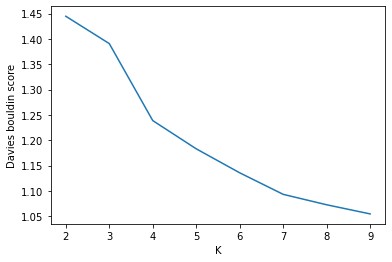

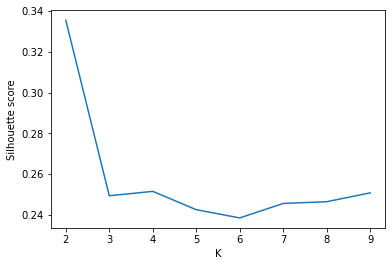

In [13]:
db_score = [0 for i in range(2,10)]
s_score = [0 for i in range(2,10)]

db_score_temp = [0 for i in range(200)]
s_score_temp = [0 for i in range(200)]



for num_clusters in  range(2, 10):
    for j in range(200):
        model_bkm = MiniBatchKMeans(n_clusters=num_clusters,random_state=j*10000)
        model_bkm.fit(X_scaled)
        model_bkm.predict(X_scaled)
        labels = model_bkm.labels_
        
        db_score_temp[j] = davies_bouldin_score(X_scaled, labels)
        s_score_temp[j] = silhouette_score(X_scaled, labels, metric = 'euclidean')
    
    db_score[num_clusters-2] = np.mean(db_score_temp)
    s_score[num_clusters-2] = np.mean(s_score_temp)
        
        
    
plt.plot(range(2, 10), db_score)
plt.xlabel('K')
plt.ylabel('Davies bouldin score')
plt.show()
 
plt.plot(range(2, 10), s_score)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()



It seems that the model (low db-score and high silhouette score) is with 5 clusters because it maximize the silhouette with a much lower davies bouldin score than for two clusters. 

#### Scoring with Birch

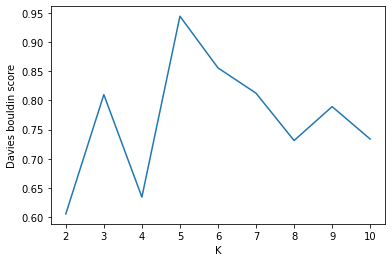

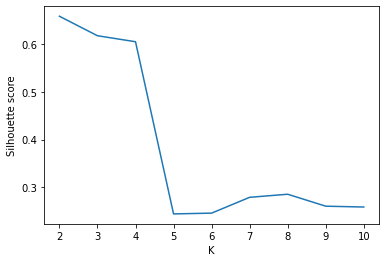

In [14]:
max_cluster = 11
db_score = [0 for i in range(2,max_cluster)]
s_score = [0 for i in range(2,max_cluster)]
 
for num_clusters in  range(2,max_cluster ):
  
    model_birch = Birch(threshold=0.75,branching_factor=15, n_clusters =num_clusters)
    model_birch.fit(X_scaled)
    model_birch.predict(X_scaled)
    labels = model_birch.labels_
    
    db_score[num_clusters-2] = davies_bouldin_score(X_scaled, labels)
    s_score[num_clusters-2] = silhouette_score(X_scaled, labels, metric = 'euclidean')
    
plt.plot(range(2, max_cluster), db_score)
plt.xlabel('K')
plt.ylabel('Davies bouldin score')
plt.show()
 
plt.plot(range(2, max_cluster), s_score)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()


From this algorithm 4 seems to be the best number of clusters. 

#### Scoring with agglomerative clustering

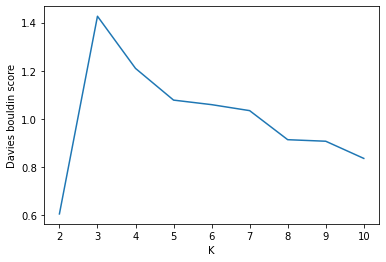

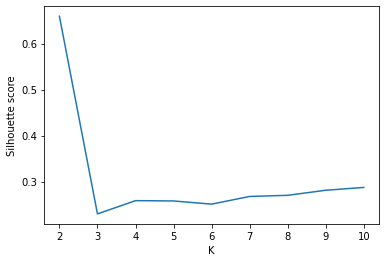

In [15]:
max_cluster = 11
db_score = [0 for i in range(2,max_cluster)]
s_score = [0 for i in range(2,max_cluster)]
 
for num_clusters in  range(2,max_cluster ):
  
    model_agl = AgglomerativeClustering(n_clusters=num_clusters, compute_distances= True) 
    model_agl.fit_predict(X_scaled)
    labels = model_agl.labels_
    
    db_score[num_clusters-2] = davies_bouldin_score(X_scaled, labels)
    s_score[num_clusters-2] = silhouette_score(X_scaled, labels, metric = 'euclidean')
    
plt.plot(range(2, max_cluster), db_score)
plt.xlabel('K')
plt.ylabel('Davies bouldin score')
plt.show()
 
plt.plot(range(2, max_cluster), s_score)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

In [16]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

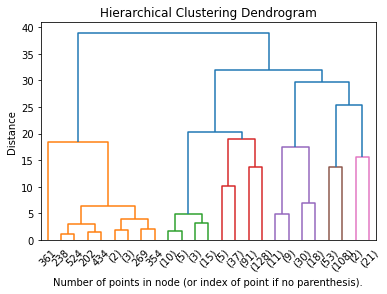

In [17]:
alg_cst = AgglomerativeClustering(n_clusters= 5, compute_distances= True )
alg_cst.fit(X_scaled)


plt.title('Hierarchical Clustering Dendrogram')

plot_dendrogram(alg_cst, truncate_mode='level', p=4,color_threshold = 20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Distance')
plt.show()

From here 5 or 7 seems to be the best number of clusters, we should try to see either the size of the clusters and the interpretability to compare the best number. 

### Day-Cluster interpretability & final method selection

##### Size of cluster compairson 

In [18]:
model_bkm = MiniBatchKMeans(n_clusters=5, random_state=100)
agl_cst5 = AgglomerativeClustering(n_clusters=5)
agl_cst7 = AgglomerativeClustering(n_clusters=7)
model_birch = Birch(threshold=0.75,branching_factor=15, n_clusters = 4)

models = [model_bkm,agl_cst5,agl_cst7,model_birch]

for model in models :
    model.fit(X_scaled)
    print('Cluster size of model ' + str(model) + ' is ' + str(np.unique(model.labels_, return_counts=True)[1]) )

Cluster size of model MiniBatchKMeans(n_clusters=5, random_state=100) is [179 282  66  11  20]
Cluster size of model AgglomerativeClustering(n_clusters=5) is [294  12  23  68 161]
Cluster size of model AgglomerativeClustering(n_clusters=7) is [ 12  68  23 219 161  33  42]
Cluster size of model Birch(branching_factor=15, n_clusters=4, threshold=0.75) is [537  11   9   1]


The Birch algorithm is not interesting as soon as we have a cluster of size one and seven clusters is maybe too much to understand. 

In [19]:
bkm_predicted =[]
agl5_predicted =[]

predicted = [bkm_predicted,agl5_predicted]
repartition_with_cluster = repartition.copy()

title = ['Minibatch_cluster','Agl5_cluster']
for i,model in enumerate(models[:2]):
    predicted[i] = model.fit_predict(X_scaled)
    repartition_with_cluster[title[i]] = predicted[i]

In [20]:
repartition_with_cluster

,date,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,Minibatch_cluster,Agl5_cluster
0,20190223,0.548995,0.161494,0.018807,0.052588,0.165051,0.012909,0.040155,1,0
1,20191024,0.458000,0.137497,0.012757,0.041800,0.297091,0.020638,0.032216,0,4
2,20190515,0.331434,0.115258,0.369043,0.028345,0.121249,0.009021,0.025650,3,1
3,20200519,0.613377,0.157901,0.013581,0.055884,0.093339,0.017059,0.048858,1,0
4,20191221,0.504338,0.136480,0.017042,0.074415,0.221581,0.013571,0.032573,0,4
...,...,...,...,...,...,...,...,...,...,...
553,20190220,0.517878,0.162295,0.019986,0.059776,0.177648,0.022053,0.040366,0,4
554,20190221,0.494197,0.156573,0.018432,0.051685,0.149088,0.091252,0.038773,4,2
555,20190422,0.523041,0.157847,0.014414,0.040364,0.210232,0.015068,0.039033,0,0
556,20200106,0.530180,0.159465,0.023477,0.056872,0.176899,0.015737,0.037371,0,4


Now we have to group by 

##### Minibatch interpretability

In [21]:
repartition_with_cluster.drop(columns=['Agl5_cluster','date']).groupby(by = 'Minibatch_cluster').mean().style.highlight_max(axis=0)

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
Minibatch_cluster,,,,,,,
0,0.499383,0.155970,0.018533,0.051734,0.220988,0.017851,0.035542
1,0.569815,0.161831,0.018828,0.048076,0.143783,0.014987,0.042681
2,0.543829,0.186289,0.016077,0.088731,0.117214,0.013387,0.034473
3,0.301429,0.102379,0.415619,0.033417,0.114781,0.009974,0.022403
4,0.487840,0.269882,0.018719,0.041180,0.111233,0.036147,0.034999


Minibatch cluster desciption : 
Cluster 0 : lots of curious (low activity,curious), rather large number of (medium activity, VEH focussed) adn small number of (low activity, VEH focussed), lots of (medium, browsers) , very fiew bouncers, normal rate (compared to other classes) of (low activity,browsers), average number (compared to other classes) of Avid users. 
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5

##### Agl5 interpretability

In [22]:
repartition_with_cluster.drop(columns=['Minibatch_cluster','date']).groupby(by = 'Agl5_cluster').mean().style.highlight_max(axis=0)

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
Agl5_cluster,,,,,,,
0,0.564417,0.164259,0.018855,0.047514,0.148431,0.014179,0.042345
1,0.311192,0.105757,0.395665,0.034110,0.119870,0.010363,0.023043
2,0.512296,0.225575,0.019010,0.044957,0.120519,0.040683,0.036960
3,0.544639,0.182488,0.017203,0.087301,0.120039,0.013679,0.034652
4,0.500320,0.156615,0.016991,0.052898,0.219349,0.018503,0.035324


Cluster 0: lots of (Curious, low), rest average with the other clusters, mawimum of (avid users,high) --> **lots of connexion, but higher number of active user than cluster 2 so probably more time spent on the website.**  

Cluster 1: few (Curious,low) compared to the others, lots of (VEH focussed, low), few avid users, minimum number of users with average activity( cluster 1 and 3) --> **low activity rate in general, few connections but rather from people who what they want, they have a purpose (few pages visited, maybe landing directly on the page they wanted).**

Cluster 2: lots of (Curious, low), lots of (Medium, VEH foccused), lots of (low,browsers) --> **lots of connexions, active day with but with more page viewed then cluster 0 (more browsers)**

Cluster 3 : lots of (Medium, browsers) and (Medium, VEH focused) --> **The day were the people with a medium activity are the most connected : lots of connections and high time spent on the website and lots of pages viewed but also vehicule pages.**

Cluster 4: lots of bouncers --> **lots of bouncers during this day**

#### Clusterization method selection 

Agglomerative_5 seems to be more easy to understand. 

In [23]:
repartition_with_cluster.drop(columns = 'Minibatch_cluster', inplace = True)

### Retrieving KPIs and other attributes on the training days

In [265]:
sql = """SELECT date,sum(bounces) AS KPI1_Bounces_tot, 
         Sum(session_veh) AS KPI2_Sess_VEH,
         sum(configuration_started) AS KPI3_config_started,
         Sum(configuration_engage) AS KPI4_config_engaged,
        sum(hits) AS hits,
        sum(timeonsite) AS timonesite , 
        sum(pageviews) AS pageviews, 
        sum(session_108) as sess_108,
        sum(session_208) as sess_208,
        sum(session_308) as sess_308,
        sum(session_508) as sess_508,
        sum(session_2008) as sess_2008,
        sum(session_3008) as sess_3008,
        sum(session_5008) as sess_5008,
        sum(session_nbveh) as sess_nb_veh,
        sum(number_of_product_detail) AS prod_detail, 
        sum(number_of_product_click) as prod_click,
        sum(number_of_add_to_cart) AS add_to_cart,
        SUM(CASE
        WHEN devicecategory='desktop' THEN
        1
        ELSE 0 END) AS devicecategory_desktop, SUM(CASE
        WHEN devicecategory='tablet' THEN
        1
        ELSE 0 END) AS devicecategory_tablet, SUM(CASE
        WHEN devicecategory='mobile' THEN
        1
        ELSE 0 END) AS devicecategory_mobile, SUM(CASE
        WHEN devicecategory='unknown' THEN
        1
        ELSE 0 END) AS devicecategory_unknown, 
        count(session) as nb_sess
FROM "group8db_psa_ga"."train_dataset_session"
GROUP BY  (date); """

execution_id = run_query(sql,database, s3_output)
time.sleep(20)

Train_KPI = obtain_dataframe_from_s3(bucket,execution_id)
for i in range(1,Train_KPI.shape[1]-1): 
    Train_KPI[Train_KPI.columns[i]] = Train_KPI[Train_KPI.columns[i]]/Train_KPI['nb_sess'] 
    
Train_KPI_repartition = Train_KPI.merge(repartition_with_cluster,on = 'date')
week_days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

#retrieving the KPIs and other attributes on the session-cluster repartition train set
Train_KPI_repartition['dayofweek'] = [week_days[y] for y in pd.to_datetime([str(i) for i in Train_KPI['date']],format= '%Y%m%d').weekday]


Train_KPI_repartition =  Train_KPI_repartition.set_index('date')

Train_KPI_repartition.head(10)

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged,hits,timonesite,pageviews,sess_108,sess_208,sess_308,...,nb_sess,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,Agl5_cluster,dayofweek
date,,,,,,,,,,,,,,,,,,,,,
20190328,0.266770,0.465643,0.096092,0.063905,14.265095,205.597802,4.514137,0.027235,0.155720,0.108733,...,126015,0.584359,0.164925,0.014633,0.050954,0.128389,0.013705,0.043035,0,Thursday
20190920,0.292032,0.510995,0.092701,0.078379,24.817758,187.388511,4.060561,0.039450,0.106377,0.108265,...,134475,0.577981,0.129191,0.016687,0.041792,0.174382,0.020428,0.039539,4,Friday
20191218,0.394614,0.557496,0.121172,0.080846,14.439417,171.557756,3.698126,0.036017,0.167002,0.082458,...,153872,0.483122,0.144159,0.057873,0.063260,0.203604,0.014155,0.033827,4,Wednesday
20190828,0.268127,0.516727,0.121302,0.079604,17.467137,208.020283,4.404666,0.037158,0.103390,0.114400,...,124441,0.581336,0.155423,0.022557,0.044133,0.133276,0.019359,0.043916,0,Wednesday
20200710,0.315922,0.498094,0.078966,0.056111,17.272733,189.735313,3.818877,0.031849,0.144267,0.077304,...,137211,0.566245,0.183928,0.014000,0.044209,0.114255,0.036192,0.041170,2,Friday
20190224,0.271702,0.575903,0.101832,0.065989,14.277623,203.032737,4.634443,0.050011,0.091991,0.102730,...,130371,0.557148,0.160036,0.019383,0.053056,0.157619,0.012741,0.040017,0,Sunday
20190605,0.305137,0.526192,0.097198,0.059925,12.999509,194.803165,4.034201,0.036815,0.119454,0.091343,...,148769,0.532046,0.142476,0.023500,0.043618,0.205903,0.010486,0.041971,0,Wednesday
20200229,0.375653,0.592721,0.138735,0.087122,14.622068,161.225850,3.661419,0.033610,0.126584,0.079036,...,152247,0.527715,0.169691,0.011501,0.053242,0.191354,0.014273,0.032224,4,Saturday
20190108,0.217545,0.459433,0.103617,0.067087,14.258001,204.196512,4.478512,0.035065,0.104200,0.095277,...,116670,0.542333,0.207466,0.018617,0.048719,0.128962,0.015308,0.038596,0,Tuesday


### Visualizing the day clusters 

#### Cluster visualization with PCA

In [60]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA()
X_pca = pca.fit_transform(Train_KPI_repartition.loc[:,["cluster_0", "cluster_1","cluster_2", "cluster_3","cluster_4", "cluster_5", "cluster_6"]])

In [61]:
pca.explained_variance_ratio_

array([5.02736936e-01, 3.26040094e-01, 1.43662409e-01, 2.19885881e-02,
       4.66365852e-03, 9.08314381e-04, 5.79418094e-32])

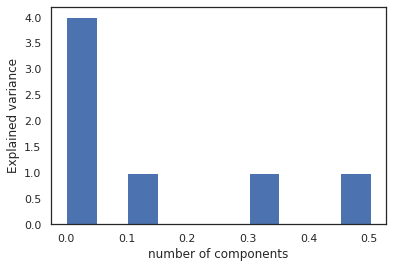

In [62]:
plt.hist(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('Explained variance')
plt.xticks(ticks = np.arange(0,0.6,0.1),label = [str(i) for i in np.arange(0,6)])
plt.show()

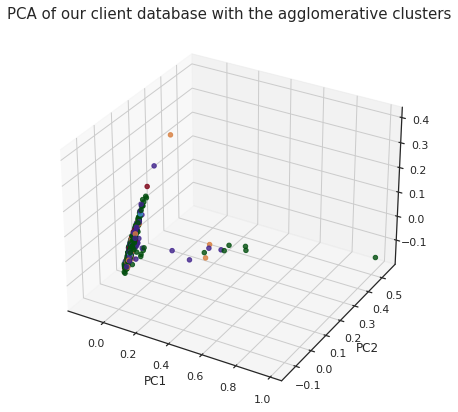

In [63]:
colordic = {0 : '#004D0D', 1 : '#3F91CF' , 2 : "#7d0014", 3 : "#D77D3C", 4 :'#40228C'}


plt.figure(figsize = (15,8))
sns.set_theme(style = 'white')

ax2 = plt.subplot(1,2,2, projection = '3d')
color = pd.Series(predicted[1].copy()).replace(colordic)
ax2.scatter(X_pca[:,0], X_pca[:, 1], X_pca[:,2], c= color, alpha=.8)
ax2.set_title('PCA of our client database with the agglomerative clusters', fontdict = {'fontsize' : 15})
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

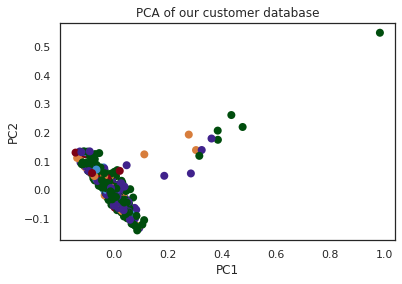

In [64]:
plt.figure()
lw = 2

plt.scatter(X_pca[:, 0], X_pca[:, 1],lw=lw, c = color)
    
plt.title('PCA of our customer database')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

#### Digging deeper into day-cluster vizualisation

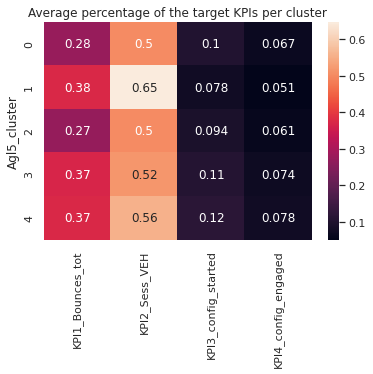

In [67]:
sns.heatmap(Train_KPI_repartition.loc[:, ['Agl5_cluster', 'KPI1_Bounces_tot', 'KPI2_Sess_VEH',
       'KPI3_config_started', 'KPI4_config_engaged']].groupby(by= 'Agl5_cluster').mean(), annot= True)
plt.title('Average percentage of the target KPIs per cluster');

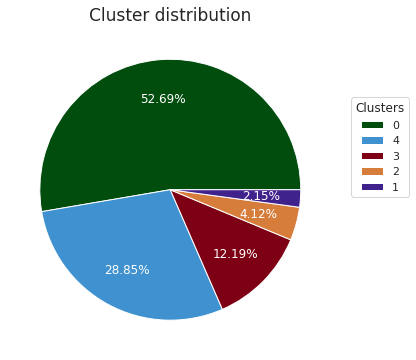

In [69]:
plt.figure(figsize= (10,10), clear = True)
Train_KPI_repartition['Agl5_cluster'].value_counts().plot.pie(textprops={'color':"w"},pctdistance=0.7,autopct='%.2f%%',figsize=(6,6), colors = colordic.values(), labels=None)
plt.title("Cluster distribution",fontsize=17,ha='center')
plt.ylabel('')
plt.legend(title = 'Clusters' ,labels=Train_KPI_repartition['Agl5_cluster'].value_counts().index, loc="best",bbox_to_anchor=(1, 0.25, 0.25, 0.55))
plt.show()

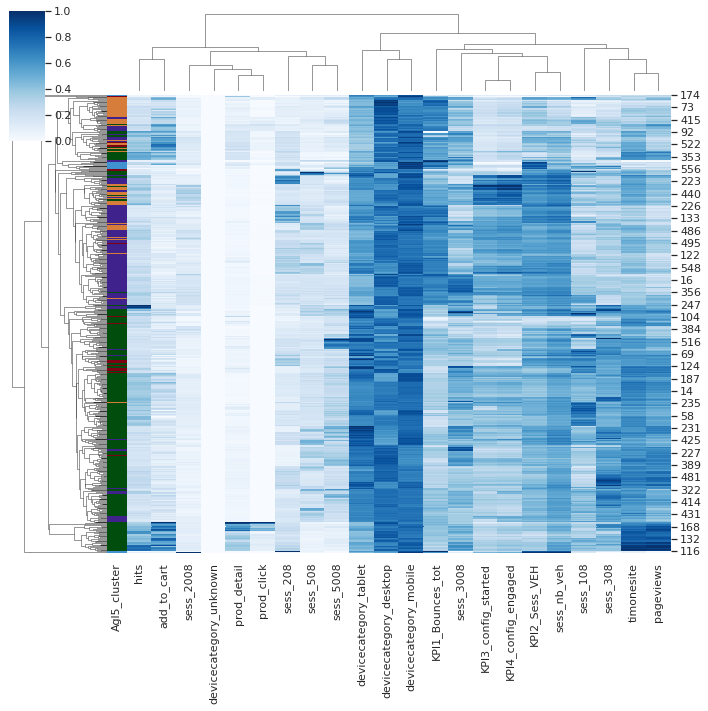

In [91]:
df = Train_KPI_repartition.loc[:,['KPI1_Bounces_tot', 'KPI2_Sess_VEH', 'KPI3_config_started',
       'KPI4_config_engaged', 'hits', 'timonesite', 'pageviews', 'sess_108',
       'sess_208', 'sess_308', 'sess_508', 'sess_2008', 'sess_3008',
       'sess_5008', 'sess_nb_veh', 'prod_detail', 'prod_click', 'add_to_cart',
       'devicecategory_desktop', 'devicecategory_tablet',
       'devicecategory_mobile', 'devicecategory_unknown', 'nb_sess',
       'Agl5_cluster']]
df = df.drop(columns= ['nb_sess'])
clusters = df.pop('Agl5_cluster')
row_colors = clusters.map(colordic)
sns.clustermap(data = df,
               row_colors= row_colors,
               dendrogram_ratio = 0.15,
               standard_scale= True, cmap = 'Blues');

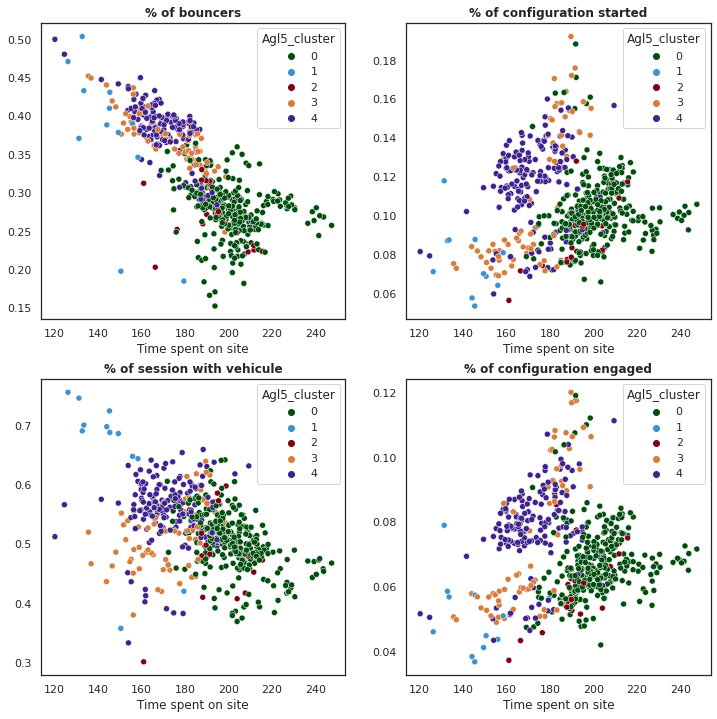

In [93]:

f, axs = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw=dict(width_ratios=[3, 3]))

to_plot = ['KPI1_Bounces_tot','KPI3_config_started','KPI2_Sess_VEH','KPI4_config_engaged' ]
titles = ['% of bouncers', '% of configuration started','% of session with vehicule','% of configuration engaged']


for i,var_kpi in enumerate(to_plot) :
    if i % 2==0:
        ax_y=0
    else:
        ax_y=1
    
    ax_x=int(i/2)
            
    sns.scatterplot(data = Train_KPI_repartition.loc[:,['KPI1_Bounces_tot', 'KPI2_Sess_VEH', 'KPI3_config_started',
       'KPI4_config_engaged', 'hits', 'timonesite', 'pageviews', 'sess_108',
       'sess_208', 'sess_308', 'sess_508', 'sess_2008', 'sess_3008',
       'sess_5008', 'sess_nb_veh', 'prod_detail', 'prod_click', 'add_to_cart',
       'devicecategory_desktop', 'devicecategory_tablet',
       'devicecategory_mobile', 'devicecategory_unknown', 'nb_sess',
       'Agl5_cluster']], 
                    x= 'timonesite', 
                    y = var_kpi ,
                    hue = "Agl5_cluster",
                    palette=colordic, ax = axs[ax_x,ax_y])
    
    axs[ax_x,ax_y].set_ylabel('')
    axs[ax_x,ax_y].set_xlabel('Time spent on site')
    axs[ax_x,ax_y].set_title(titles[i],{'fontsize': 12, 'fontweight':  'demibold'})

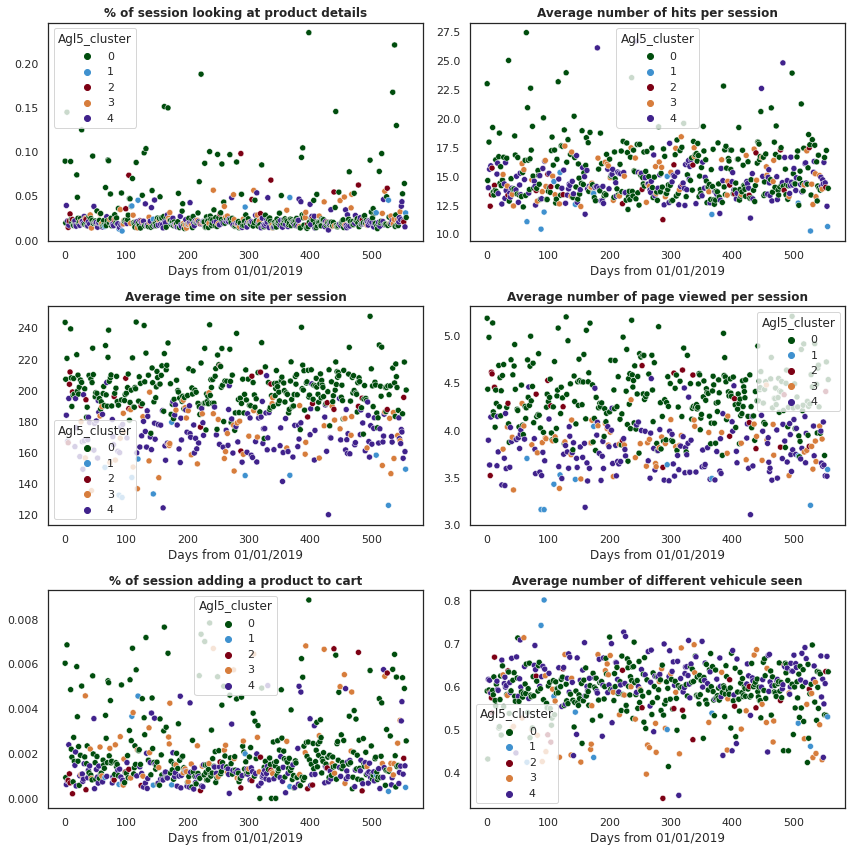

In [96]:
f.clear()
f, axs = plt.subplots(3, 2, figsize=(12, 12), gridspec_kw=dict(width_ratios=[3, 3]))

Train_only_KPI = Train_KPI_repartition.loc[:,['KPI1_Bounces_tot', 'KPI2_Sess_VEH', 'KPI3_config_started',
       'KPI4_config_engaged', 'hits', 'timonesite', 'pageviews', 'sess_108',
       'sess_208', 'sess_308', 'sess_508', 'sess_2008', 'sess_3008',
       'sess_5008', 'sess_nb_veh', 'prod_detail', 'prod_click', 'add_to_cart',
       'devicecategory_desktop', 'devicecategory_tablet',
       'devicecategory_mobile', 'devicecategory_unknown', 'nb_sess',
       'Agl5_cluster']]

Train_only_KPI['date'] = Train_only_KPI.index

to_plot = ['prod_detail','hits','timonesite','pageviews', 'add_to_cart', 'sess_nb_veh' ]
titles = ['% of session looking at product details', 'Average number of hits per session',
          'Average time on site per session','Average number of page viewed per session', 
          '% of session adding a product to cart','Average number of different vehicule seen']


for i,var_kpi in enumerate(to_plot) :
    if i % 2==0:
        ax_y=0
    else:
        ax_y=1
    
    ax_x=int(i/2)
            
    sns.scatterplot(data = Train_only_KPI.sort_values(by = 'date', ascending= True), 
                    x= Train_only_KPI.sort_values(by = 'date', ascending= True).index, 
                    y = var_kpi ,
                    hue = "Agl5_cluster",
                    palette=colordic, ax = axs[ax_x,ax_y])
    
    axs[ax_x,ax_y].set_ylabel('')
    axs[ax_x,ax_y].set_xlabel('Days from 01/01/2019')
    axs[ax_x,ax_y].set_title(titles[i],{'fontsize': 12, 'fontweight':  'demibold'})
    
if len(to_plot) % 2 != 0:
    plt.plot(ax= axs[axs.shape[0]-1,axs.shape[1]-1], frameon = False)
    
f.tight_layout()

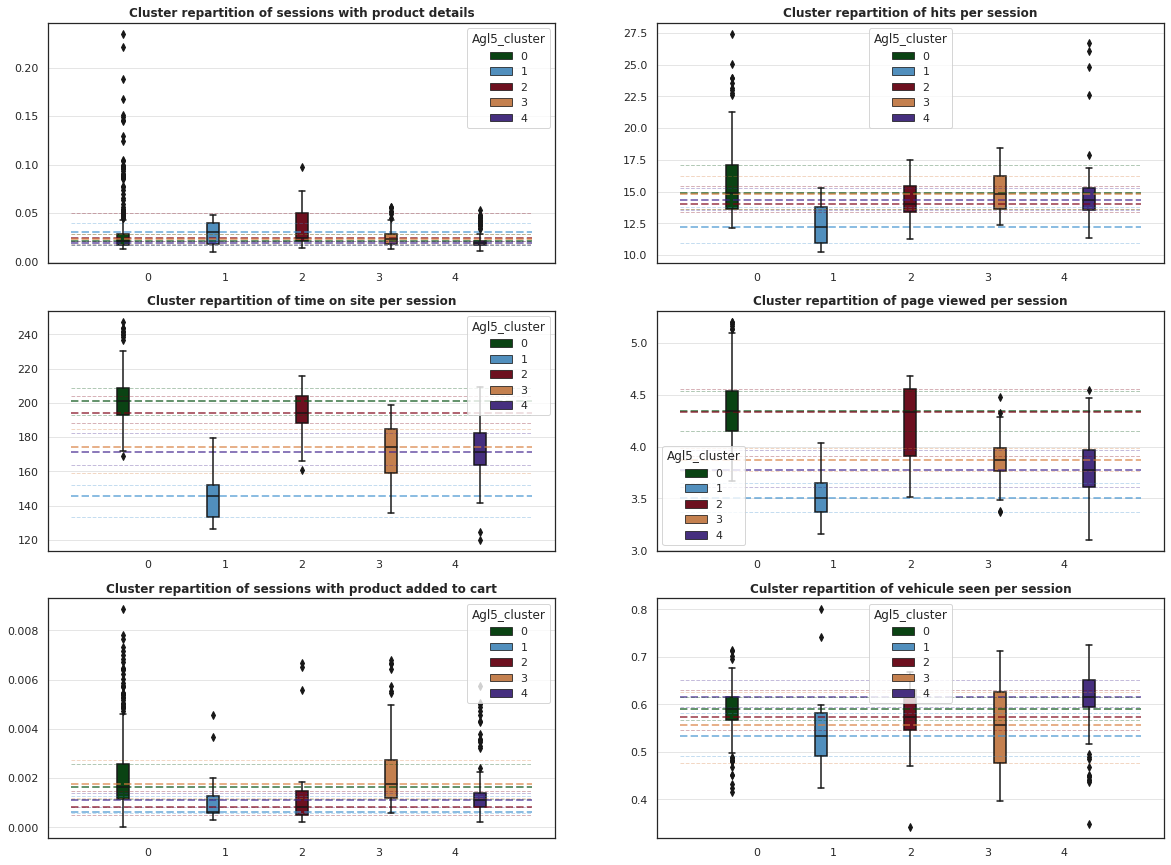

In [97]:
KPIs_quantiles= Train_only_KPI.groupby(by = 'Agl5_cluster').quantile([0.0225,0.25,0.5,0.75,0.9775]).unstack()
idx = pd.IndexSlice

f, axs = plt.subplots(3, 2, figsize=(20, 15), gridspec_kw=dict(width_ratios=[3, 3]))
to_plot = ['prod_detail','hits','timonesite','pageviews', 'add_to_cart', 'sess_nb_veh']
titles = ['Cluster repartition of sessions with product details', 'Cluster repartition of hits per session',
          'Cluster repartition of time on site per session','Cluster repartition of page viewed per session', 
          'Cluster repartition of sessions with product added to cart','Culster repartition of vehicule seen per session']

for i,var_kpi in enumerate(to_plot) :
    if i % 2==0:
        lab_x =-1
        ax_y=0
    else:
        lab_x= 4.32
        ax_y=1
    
    ax_x=int(i/2)
    


    sns.boxplot(data = Train_only_KPI.sort_values(by = 'date', ascending= True), 
                        x= 'Agl5_cluster', 
                        y = var_kpi ,
                        hue = "Agl5_cluster",
                        palette=colordic, ax = axs[ax_x,ax_y])
    axs[ax_x,ax_y].grid(which = 'both', axis = 'y', color = 'grey', alpha = 0.2)
    
    
    axs[ax_x,ax_y].set_ylabel('')
    axs[ax_x,ax_y].set_xlabel('')
    axs[ax_x,ax_y].set_title(titles[i],{'fontsize': 12, 'fontweight':  'demibold'})



    #Q1 lines
    axs[ax_x,ax_y].hlines(y =  KPIs_quantiles.loc[:,idx[var_kpi,0.25]], xmin = -1, xmax = 5, colors = colordic.values(), alpha = 0.3, linestyles = 'dashed', lw= 1)

    #mean lines
    axs[ax_x,ax_y].hlines(y =  KPIs_quantiles.loc[:,idx[var_kpi,0.5]], xmin = -1, xmax = 5, colors = colordic.values(), alpha = 0.6, linestyles = 'dashed', lw= 2)


    #Q3 lines
    axs[ax_x,ax_y].hlines(y =  KPIs_quantiles.loc[:,idx[var_kpi,0.75]], xmin = -1, xmax = 5, colors = colordic.values(), alpha = 0.3, linestyles = 'dashed', lw= 1)




   # for j in range(0,5):
     #   axs[ax_x,ax_y].annotate(text = 'Mean, Cluster '+ str(j) + ' = ' + str(round(KPIs_quantiles.loc[j,idx[var_kpi,0.5]])), xy = (lab_x, KPIs_quantiles.loc[j,idx[var_kpi,0.5]]),size = 8, weight = 'demibold')

In [98]:
KPIs_quantiles.loc[:,idx[[i for i in Train_with_KPI.columns if 'KPI' in i ], [0.25,0.75]]]

KPI1_Bounces_tot           KPI2_Sess_VEH            \
                         0.25      0.75          0.25      0.75   
Agl5_cluster                                                      
0                    0.260748  0.294288      0.478836  0.529856   
1                    0.365003  0.431647      0.646734  0.706360   
2                    0.241554  0.310900      0.471233  0.567633   
3                    0.344985  0.390854      0.474058  0.554438   
4                    0.363561  0.399796      0.530928  0.588996   

             KPI3_config_started           KPI4_config_engaged            
                            0.25      0.75                0.25      0.75  
Agl5_cluster                                                              
0                       0.093971  0.110795            0.061087  0.072558  
1                       0.067962  0.087831            0.043156  0.057030  
2                       0.080296  0.106116            0.053604  0.068421  
3                       0.078774  0.141525            0.055044  0.092621  
4                       0.105451  0.130588            0.073733  0.085635

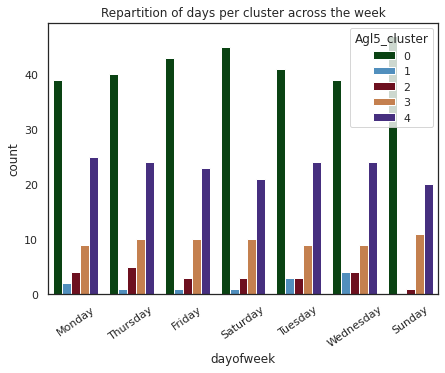

In [99]:
f, axs = plt.subplots(1, 1, figsize=(7, 5))

sns.countplot(x = 'dayofweek', hue = 'Agl5_cluster' , data = Train_KPI_repartition.loc[:,['KPI1_Bounces_tot', 'KPI2_Sess_VEH', 'KPI3_config_started',
       'KPI4_config_engaged', 'hits', 'timonesite', 'pageviews', 'sess_108',
       'sess_208', 'sess_308', 'sess_508', 'sess_2008', 'sess_3008',
       'sess_5008', 'sess_nb_veh', 'prod_detail', 'prod_click', 'add_to_cart',
       'devicecategory_desktop', 'devicecategory_tablet',
       'devicecategory_mobile', 'devicecategory_unknown', 'nb_sess',
       'Agl5_cluster', 'dayofweek']], palette= colordic, ax=axs,dodge = True)
plt.title('Repartition of days per cluster across the week')
axs.set_xticklabels(labels =axs.get_xticklabels(), rotation = 35);


<a id='III'></a>

# III. Sampling the test days and get their session-cluster repartition

- get the different days in the test sessions
- create an empty dataframe to store each day described by its session-cluster repartition
- for each day :
 randomly select 70% of the sessions using a bernoulli law, 
 then compute the 7 session cluster repartitions using these selected sessions, retreive also other attributes (the same we retrieved for the training days),
 append the day to our empty dataframe 

- we end up with 28 days described by the 7-session cluster repartition

Why going for a Bernoulli law to sample sessions of a day ? 

 Note from PRESTO documentation (tablesample bernoulli function) : Each row is selected to be in the table sample with a probability of the sample percentage. When a table is sampled using the Bernoulli method, all physical blocks of the table are scanned and certain rows are skipped (based on a comparison between the sample percentage and a random value calculated at runtime).

The probability of a row being included in the result is independent from any other row. This does not reduce the time required to read the sampled table from disk. It may have an impact on the total query time if the sampled output is processed further.
===> at each row it take a random value from bernoulli (p=0.7) and compare whether it is below or above 0.7


In [307]:
distinct_dates_query = """ SELECT DISTINCT(date) FROM "group8db_psa_ga"."test_dataset_session" """
distinct_dates = query_to_df(distinct_dates_query)

In [ ]:

### WILL TAKE 28*5SEC TO RUN == 2,3mins ###
test_days_sampled = pd.DataFrame(columns=['date', 'cluster_0','cluster_1', 'cluster_2', 'cluster_3' ,'cluster_4' ,'cluster_5', 'cluster_6','hits','timonesite','pageviews','sess_108','sess_208','sess_308','sess_508','sess_2008','sess_3008','sess_5008','sess_nb_veh','prod_detail','prod_click','add_to_cart','devicecategory_desktop','devicecategory_mobile','devicecategory_tablet','devicecategory_unknown','total'])

#Extraction of information per day
for day in distinct_dates.iloc[:,0]:
    get_repartition_by_day_query = """SELECT sampled_day.date,
         SUM(CASE
    WHEN kmeans_cluster=0 THEN
    1
    ELSE 0 END) AS cluster_0, SUM(CASE
    WHEN kmeans_cluster=1 THEN
    1
    ELSE 0 END) AS cluster_1, SUM(CASE
    WHEN kmeans_cluster=2 THEN
    1
    ELSE 0 END) AS cluster_2, SUM(CASE
    WHEN kmeans_cluster=3 THEN
    1
    ELSE 0 END) AS cluster_3, SUM(CASE
    WHEN kmeans_cluster=4 THEN
    1
    ELSE 0 END) AS cluster_4, SUM(CASE
    WHEN kmeans_cluster=5 THEN
    1
    ELSE 0 END) AS cluster_5, SUM(CASE
    WHEN kmeans_cluster=6 THEN
    1
    ELSE 0 END) AS cluster_6,
    sum(hits) AS hits,
    sum(timeonsite) AS timonesite , 
    sum(pageviews) AS pageviews, 
    sum(session_108) as sess_108,
    sum(session_208) as sess_208,
    sum(session_308) as sess_308,
    sum(session_508) as sess_508,
    sum(session_2008) as sess_2008,
    sum(session_3008) as sess_3008,
    sum(session_5008) as sess_5008,
    sum(session_nbveh) as sess_nb_veh,
    sum(number_of_product_detail) AS prod_detail, 
    sum(number_of_product_click) as prod_click,
    sum(number_of_add_to_cart) AS add_to_cart,
    SUM(CASE
    WHEN devicecategory_encrypted=0 THEN
    1
    ELSE 0 END) AS devicecategory_desktop, SUM(CASE
    WHEN devicecategory_encrypted=1 THEN
    1
    ELSE 0 END) AS devicecategory_mobile, SUM(CASE
    WHEN devicecategory_encrypted=2 THEN
    1
    ELSE 0 END) AS devicecategory_tablet, SUM(CASE
    WHEN devicecategory_encrypted=3 THEN
    1
    ELSE 0 END) AS devicecategory_unknown,
    COUNT (*) AS total
FROM (SELECT * FROM "group8db_psa_ga"."test_dataset_session" tablesample bernoulli (70)
 WHERE date = '{}') as sampled_day
 group by date  """.format(day)
    get_repartition_by_day = query_to_df( get_repartition_by_day_query)
    test_days_sampled = test_days_sampled.append(get_repartition_by_day, ignore_index=True)

#Computing the average/ the percentage for each comlumns    
for i in test_days_sampled.columns.to_list()[1:-1]:
    test_days_sampled.loc[:,i] =  test_days_sampled.loc[:,i]/test_days_sampled["total"]




test_days_sampled.drop(columns=['total'],inplace=True)
test_days_sampled = test_days_sampled.set_index('date')
test_days_sampled.head()   

<a id='IV'></a>

# IV. Predicting day cluster on sampled test days and identifying their relevant training days

### Buidling the machine learning pipeline to select best predictive model

##### I.Data preparation

Loading data and  feature selection
Note : we only take the session cluster repartition features, we tried to add other attributes in the pipeline we did not increase the accuracy. 

In [178]:
X = Train_KPI_repartition.loc[:,['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6']]
y = Train_KPI_repartition.loc[:,['Agl5_cluster']]
y= pd.Series(y['Agl5_cluster'])

Splitting the data

In [179]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

Scaling the features

In [180]:
from sklearn.preprocessing import StandardScaler
encoder = StandardScaler()

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


##### ii.Modelling

##### a) With KNN

Hyperparameter tuning (note: might slightly change due to the sampling for constructing the test days)

In [183]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=5, scoring = "accuracy")
grid_search_cv.fit(X_train, y_train)
print("Best K to select is:",grid_search_cv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best K to select is: {'n_neighbors': 1}


Validating 

In [185]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5, scoring="accuracy",return_train_score=True)
knn_scores = pd.DataFrame(data=[], columns=["accuracy_val_score", "accuracy_train_score"], index = np.linspace(1,5,5))
knn_scores['accuracy_val_score'] = cv_results['test_score']
knn_scores['accuracy_train_score'] = cv_results['train_score']

print("###  Mean training scores vs Mean validation scores:  ### ")
print("Mean training scores:", knn_scores['accuracy_train_score'].mean(), "Mean validation scores:",  knn_scores['accuracy_val_score'].mean())
print()
print("###  Std training scores vs Std validation scores:  ### ")
print("Std training scores:", knn_scores['accuracy_train_score'].std(), "Std validation scores:", knn_scores['accuracy_val_score'].std())


###  Mean training scores vs Mean validation scores:  ### 
Mean training scores: 1.0 Mean validation scores: 0.994142259414226

###  Std training scores vs Std validation scores:  ### 
Std training scores: 0.0 Std validation scores: 0.003742373184100082


###### b) With a decsion tree algorithm

Hyperparameter tuning

In [186]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

threefoldaccuracy = [0 for i in range(20)]  

for i in range(1,21):
    clf = DecisionTreeClassifier(max_depth=i, random_state=42)
    accuracy=cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    threefoldaccuracy[i-1]=np.mean(accuracy)

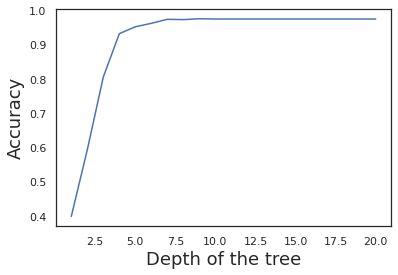

In [187]:
import matplotlib.pyplot as plt
num=np.arange(1,21)
plt.plot(num, threefoldaccuracy)
plt.xlabel("Depth of the tree", fontsize=18)    
plt.ylabel("Accuracy", fontsize=18);

In [188]:
print("Optimal tree depth is:",threefoldaccuracy.index(max(threefoldaccuracy))+1)

Optimal tree depth is: 9


Validating

In [189]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(DecisionTreeClassifier(max_depth=9), X_train, y_train, cv=5, scoring="accuracy",return_train_score=True)
dt_scores = pd.DataFrame(data=[], columns=["accuracy_val_score", "accuracy_train_score"], index = np.linspace(1,5,5))
dt_scores['accuracy_val_score'] = cv_results['test_score']
dt_scores['accuracy_train_score'] = cv_results['train_score']

print("###  Mean training scores vs Mean validation scores:  ### ")
print("Mean training scores:", dt_scores['accuracy_train_score'].mean(), "Mean validation scores:",  dt_scores['accuracy_val_score'].mean())
print()
print("###  Std training scores vs Std validation scores:  ### ")
print("Std training scores:", dt_scores['accuracy_train_score'].std(), "Std validation scores:", dt_scores['accuracy_val_score'].std())



###  Mean training scores vs Mean validation scores:  ### 
Mean training scores: 0.994979079497908 Mean validation scores: 0.9757322175732217

###  Std training scores vs Std validation scores:  ### 
Std training scores: 0.001871186592050069 Std validation scores: 0.01461443447411964


##### iii.Selecting best model

Testing tuned models on "test set" 

In [190]:
from sklearn.metrics import accuracy_score

#training best tuned models on full training set
knn  = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

decision_tree = DecisionTreeClassifier(max_depth=9)
decision_tree.fit(X_train, y_train)
decision_tree_pred = decision_tree.predict(X_test)


print( "Test accuracy for KNN",accuracy_score(y_test, knn_pred) )
print( "Test accuracy for Decision tree",accuracy_score(y_test, decision_tree_pred) )


Test accuracy for KNN 0.9821428571428571
Test accuracy for Decision tree 0.9107142857142857


Selecting the best one

Let's go for the KNN model, with K=1 

##### iv. Predicting the clusters with best model on the test days

In [322]:
# predict on test_days_sampled

#dont forget to scale using method fitted on training days
test_days_sampled_for_predictions = test_days_sampled.copy()
test_days_sampled_for_predictions  = test_days_sampled_for_predictions.loc[:,['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6']]

In [323]:
test_days_sampled_for_predictions = encoder.transform(test_days_sampled_for_predictions)

In [324]:
#retrieve preds for the non-scaled dataframe
test_days_sampled["Agl5_cluster_predicted"] = knn.predict(test_days_sampled_for_predictions)
test_days_sampled

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,hits,timonesite,pageviews,...,sess_5008,sess_nb_veh,prod_detail,prod_click,add_to_cart,devicecategory_desktop,devicecategory_mobile,devicecategory_tablet,devicecategory_unknown,Agl5_cluster_predicted
date,,,,,,,,,,,,,,,,,,,,,
20200802,0.579655,0.190003,0.0117339,0.0398844,0.111037,0.0242705,0.0434166,19.6676,200.107,4.01205,...,0.0359776,0.592339,0.058201,0.0211664,0.00727847,0.328441,0.609893,0.0616663,0,0
20200722,0.553532,0.202412,0.014055,0.0438925,0.121016,0.0241644,0.0409281,18.1165,192.866,3.89581,...,0.0361852,0.582459,0.0553716,0.0171726,0.00573444,0.433282,0.518236,0.0484821,0,2
20200730,0.561244,0.191711,0.0118096,0.0422157,0.125327,0.0241099,0.0435824,18.279,194.664,3.88125,...,0.0302542,0.553114,0.0550065,0.019601,0.00616765,0.430637,0.518888,0.0504743,0,0
20200724,0.567396,0.20198,0.0136781,0.0435763,0.106032,0.0267818,0.0405556,18.3667,189.711,3.89672,...,0.0331422,0.571427,0.05601,0.0166881,0.00787075,0.408088,0.541656,0.0502558,0,2
20200716,0.562983,0.20781,0.0139667,0.0461068,0.0989267,0.027786,0.042421,17.7044,196.496,3.91261,...,0.0341943,0.573097,0.0571544,0.0165418,0.00582847,0.426677,0.523412,0.0499106,0,2
20200723,0.564999,0.205772,0.013934,0.0427821,0.106039,0.0247467,0.0417275,18.2171,193.727,3.91942,...,0.0349309,0.568269,0.0626178,0.0187811,0.00550756,0.422644,0.529748,0.0476079,0,2
20200714,0.535218,0.203764,0.0136755,0.0459143,0.132217,0.0325064,0.0367047,17.0802,179.052,3.79871,...,0.0381453,0.58533,0.0574289,0.0196849,0.00714131,0.349492,0.591453,0.0590548,0,2
20200806,0.562597,0.219157,0.0138562,0.0392187,0.103877,0.0173235,0.0439702,14.9082,195.269,3.88618,...,0.0363422,0.544349,0.058263,0.0222933,0.00590721,0.417331,0.532907,0.0497618,0,0
20200801,0.577922,0.196989,0.0124764,0.0410752,0.10336,0.0257846,0.0423921,18.3347,193.743,3.83595,...,0.033215,0.56101,0.0515415,0.0162887,0.00749972,0.335741,0.604553,0.0597067,0,2


### Defining the approach to find the most similar training days for each test day in a cluster

Functions definition to compare each test day to the training days belonging to same cluster

In [266]:
def test_days_similarity_per_cluster(train_days, test_days, distance_function):
    
    ## Lexicon ##
    
    #-- train_days : the training dataset, we will only use the session cluster repartion attributes to compute the similarities
    # -- test days : the test dataset, we will only use the session cluster repartion attributes to compute the similarities
    # -- distance_function : a function to compute the distance/dissimilarity between two days, can be the manhattan , euclidian distances..;
    
    ## End of Lexicon ##
    
    train_days_forsimilarity = train_days.copy()
    test_days_forsimilarity = test_days.copy()
    
    train_days_forsimilarity['date'] = train_days.index
    test_days_forsimilarity['date'] = test_days.index
    
    train_days_forsimilarity = train_days_forsimilarity.loc[:,['date','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6','Agl5_cluster']]
    test_days_forsimilarity = test_days_forsimilarity.loc[:,['date','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6','Agl5_cluster_predicted']]

    
    similarities_per_cluster = dict()
    
    #loop through all unique cluster values, assuming cluster column is the last one
    for cluster in list(test_days_forsimilarity.iloc[:,-1].unique()) : 
        
        similarities_test_days = dict()
        training_days_selected_cluster = train_days_forsimilarity.loc[train_days['Agl5_cluster'] == cluster]
        test_days_selected_cluster = test_days_forsimilarity.loc[test_days['Agl5_cluster_predicted'] == cluster]

        #for each test day in the cluster, we will compute its similarity with all training days from same cluster 
        for test in test_days_selected_cluster.iterrows():
            similarities_with_test = []

            #take a training day, compute its similarity with selected test day, and store it in a list as a tuple : the value and the date
            for train in training_days_selected_cluster.iterrows():
                similarity_for_train = distance_function(test[1][1:8].astype(float),train[1][1:8])
                similarities_with_test.append((train[1]['date'], similarity_for_train)) #we store a tuple (date of training days,similarity with the test day)

            #store  similiarites with all training days for the selected test day 
            similarities_test_days[test[1]['date']]= similarities_with_test

        #keep track on which cluster we were operating on 
        similarities_per_cluster[cluster] = similarities_test_days
        
    return similarities_per_cluster #a dict composed of training days similarities per test days dictionnary, for each cluster

In [267]:
from operator import itemgetter

def get_top_similar_training_days_per_test_day (similarities_per_cluster, k):
    ## Lexicon ##
    
    #--k : the k first similar training days we select per test day. The greater k, the more distant the last training day selected is from the test day
    #--similarities_per_cluster : a dict object computed using the test_days_similarity_per_cluster function, it depends of the distance function we used
    
    ## End Lexicon ##
    
    #initializing the dict object to get the list of most similar training days per test day
    top_similar_training_days_per_test_day = dict()
    
    #loop through each cluster of the similarities_per_cluster dict object
    for cluster in list(similarities_per_cluster.keys()):
        
        #loop through each test day of the similarities_per_cluster dict object for selected cluster
        for test_day in similarities_per_cluster[cluster]: 
            #sort the training days per similarities (from lower to higher), and take the first k 
            top_sorted_similarities = sorted(similarities_per_cluster[cluster][test_day], key=itemgetter(1))[0:k]
            top_training_days = []
            
                #store only the day from the sorted tuples (training_day, similarity with test day)
            for day,similarity in top_sorted_similarities: 
                top_training_days.append(day)
                
                #store the list of most similar training days per test day in the dict
            top_similar_training_days_per_test_day[test_day] = top_training_days
                
    return top_similar_training_days_per_test_day

Trying with the euclidian distance : the lower, the less distant the days are and so the most similar

In [268]:
from scipy.spatial.distance import euclidean , mahalanobis, correlation, canberra, braycurtis
euclidean_similarity = test_days_similarity_per_cluster(Train_KPI_repartition, test_days_sampled, euclidean)

In [270]:
euclidean_most_similar_days = get_top_similar_training_days_per_test_day (euclidean_similarity , 5)
euclidean_most_similar_days

{20200722: [20200709.0, 20190109.0, 20190113.0, 20190211.0, 20200710.0],
 20200724: [20190113.0, 20200710.0, 20200709.0, 20190109.0, 20200711.0],
 20200713: [20190109.0, 20200709.0, 20190116.0, 20190113.0, 20190114.0],
 20200719: [20190109.0, 20190113.0, 20200709.0, 20190116.0, 20200710.0],
 20200720: [20190116.0, 20190114.0, 20190109.0, 20190113.0, 20200709.0],
 20200712: [20191002.0, 20190211.0, 20200711.0, 20200710.0, 20200709.0],
 20200718: [20190113.0, 20200710.0, 20190109.0, 20200709.0, 20200711.0],
 20200716: [20190113.0, 20190109.0, 20200709.0, 20190116.0, 20200710.0],
 20200723: [20190113.0, 20200710.0, 20200709.0, 20190109.0, 20200711.0],
 20200717: [20190113.0, 20190109.0, 20200709.0, 20190116.0, 20200710.0],
 20200714: [20200709.0, 20190109.0, 20190304.0, 20191002.0, 20190211.0],
 20200801: [20190113.0, 20200710.0, 20200711.0, 20190211.0, 20200709.0],
 20200715: [20200709.0, 20190109.0, 20190113.0, 20200710.0, 20190211.0],
 20200725: [20190113.0, 20200710.0, 20200711.0, 202

<a id='V'></a>

# V. Defining different extrapolation approaches

### Defining the simple average method

In [317]:
def get_prediction_simple_average(most_similar_days,similarity_dictionnary, train_days_KPIs):
    
    #make sure we only select the target KPIs of the input training set 
    train_days_KPIs_foraverage  = train_days_KPIs.copy()
    train_days_KPIs_foraverage = train_days_KPIs_foraverage.loc[:, ['KPI1_Bounces_tot', 'KPI2_Sess_VEH',
       'KPI3_config_started', 'KPI4_config_engaged']]
    
    #Creating the dataframe to store the target KPI's predicted. 
    Test_prediction_df = pd.DataFrame(columns = train_days_KPIs_foraverage.columns.to_list())
    Test_prediction_df['date'] = test_days_sampled.index
    Test_prediction_df.set_index('date',inplace = True)

    target_KPI = train_days_KPIs_foraverage.columns.to_list()
    
    #for each test days we are going to compute the average KPI of the closest day for each KPI 
    for test_days, train_similar_days in most_similar_days.items():
        
        #Storing the average as prediction
        Test_prediction_df.loc[test_days,target_KPI[0]] = train_days_KPIs_foraverage.loc[train_similar_days,target_KPI[0]].mean()
        Test_prediction_df.loc[test_days,target_KPI[3]] = train_days_KPIs_foraverage.loc[train_similar_days,target_KPI[2]].mean()
        Test_prediction_df.loc[test_days,target_KPI[2]] = train_days_KPIs_foraverage.loc[train_similar_days,target_KPI[3]].mean()
        Test_prediction_df.loc[test_days,target_KPI[1]] = train_days_KPIs_foraverage.loc[train_similar_days,target_KPI[1]].mean()

    return Test_prediction_df 
        
    

Testing this method using our euclidean-based similarities

In [318]:
get_prediction_simple_average(euclidean_most_similar_days,euclidean_similarity,Train_KPI_repartition)

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
date,,,,
20200802,0.268066,0.496598,0.0646072,0.100772
20200722,0.274247,0.477405,0.063557,0.0942369
20200730,0.272284,0.482436,0.0607343,0.0960434
20200724,0.284278,0.478685,0.0616854,0.0905347
20200716,0.265641,0.469645,0.0659607,0.0987604
20200723,0.284278,0.478685,0.0616854,0.0905347
20200714,0.281752,0.498999,0.0648304,0.0998532
20200806,0.229931,0.478812,0.0715517,0.110592
20200801,0.290664,0.497546,0.0610575,0.0891977


### Defining the ponderated average method

Average ponderated by the distance between test and the k similar training days

In [293]:
def weighted_average(daily_KPI,distances):
  
    numerator = sum([daily_KPI[i]*distances[i] for i in range(len(daily_KPI))])
    denominator = sum(distances)
    
    return numerator/denominator

In [325]:
def get_prediction_pronderated_average(most_similar_days, similarity_dictionnary,train_days_KPIs ):
    
    #make sure we only select the target KPIs of the input training set
    train_days_KPIs_forponderated  = train_days_KPIs.copy()
    train_days_KPIs_forponderated = train_days_KPIs_forponderated.loc[:, ['KPI1_Bounces_tot', 'KPI2_Sess_VEH',
       'KPI3_config_started', 'KPI4_config_engaged']]
    
    
#Creating the dataframe to store the target KPI's predicted. 
    Test_prediction_df = pd.DataFrame(columns = train_days_KPIs_forponderated.columns.to_list())
    Test_prediction_df['date'] = test_days_sampled.index
    Test_prediction_df.set_index('date',inplace = True)

    target_KPI = train_days_KPIs_forponderated.columns.to_list()


    for test_days, train_similar_days in most_similar_days.items():

        #storing the cluster of the test day to get its distance to the closest days
        cluster_test_days = test_days_sampled.loc[test_days,'Agl5_cluster_predicted']

        predicted_bounce_rate = 0
        predicted_started_config_rate = 0
        predicted_engaged_config_rate = 0
        predicted_sess_with_VEH_rate = 0
        distances = []

        #getting the distances from the distance dictionnary
        for days in train_similar_days : 
            distances.append(pd.DataFrame(similarity_dictionnary[cluster_test_days][test_days]).set_index(0).loc[days,1])

        Test_prediction_df.loc[test_days,target_KPI[0]] = weighted_average(train_days_KPIs_forponderated.loc[train_similar_days,target_KPI[0]].to_list(), distances)
        Test_prediction_df.loc[test_days,target_KPI[3]] = weighted_average(train_days_KPIs_forponderated.loc[train_similar_days,target_KPI[3]].to_list(), distances)
        Test_prediction_df.loc[test_days,target_KPI[2]] = weighted_average(train_days_KPIs_forponderated.loc[train_similar_days,target_KPI[2]].to_list(), distances)
        Test_prediction_df.loc[test_days,target_KPI[1]] = weighted_average(train_days_KPIs_forponderated.loc[train_similar_days,target_KPI[1]].to_list(), distances)

    return Test_prediction_df

Testing this method using our euclidean-based similarities

In [326]:
get_prediction_pronderated_average(euclidean_most_similar_days,euclidean_similarity,Train_KPI_repartition)

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
date,,,,
20200802,0.267469,0.497941,0.101225,0.064962
20200722,0.269287,0.47907,0.0957514,0.0643266
20200730,0.27075,0.484881,0.0971327,0.0616809
20200724,0.293057,0.480207,0.0865691,0.0594507
20200716,0.270544,0.470405,0.0968467,0.0648908
20200723,0.292427,0.480532,0.0868674,0.0596223
20200714,0.278371,0.503806,0.10178,0.0656461
20200806,0.226984,0.4744,0.110013,0.0710056
20200801,0.296903,0.498888,0.0866099,0.0595716


### Defining the linear regression method 

Linear regression trained on the similar days

###### Packages importation

In [327]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

###### Model building

In [356]:
def get_prediction_linear_regression(most_similar_days, similarity_dictionnary, train_days_KPIs ):
    
    #make sure we only select the target KPIs of the input training set
    train_days_KPIs_foregression = train_days_KPIs.copy()
    train_days_KPIs_foregression = train_days_KPIs_foregression.loc[:, ['KPI1_Bounces_tot', 'KPI2_Sess_VEH',
       'KPI3_config_started', 'KPI4_config_engaged']]
    
    
    #Creating the dataframe to store the target KPI's predicted. 
    Test_prediction_df = pd.DataFrame(columns = train_days_KPIs_foregression.columns.to_list())
    Test_prediction_df['date'] = test_days_sampled.index
    Test_prediction_df.set_index('date',inplace = True)

    target_KPI = train_days_KPIs_foregression.columns.to_list()

    #setting the variable to use to train the model 
    variables = test_days_sampled.columns.to_list()
    del variables[-1]
    scaler = StandardScaler()
    pca= PCA(n_components=5)
    
    for test_days, train_similar_days in most_similar_days.items():

        #defining the training dataframe,(going for a PCA to remove any correlation between the features)
        X = train_days_KPIs.loc[train_similar_days,variables].copy()
        X_scaled = scaler.fit_transform(X)
        X_pca_scaled= pca.fit_transform(X_scaled)
        y = train_days_KPIs.loc[train_similar_days,target_KPI]
        

        #defining the test dataframe (the only day we want to predict)
        X_test = np.array(test_days_sampled_complete.set_index('date').loc[test_days,variables]).reshape(1,-1)
        X_test_scaled = scaler.transform(X_test)
        X_test_pca_scaled = pca.transform(X_test_scaled)
        
        #training the model
        model = MultiOutputRegressor(LinearRegression())
        model.fit(X_pca_scaled,y)
        predictions = model.predict(X_test_pca_scaled)
        predictions = predictions.tolist()[0]

        Test_prediction_df.loc[test_days,target_KPI] = predictions
        
    return Test_prediction_df

Testing this method using our euclidean-based similarities

In [359]:
get_prediction_linear_regression(euclidean_most_similar_days,euclidean_similarity,Train_KPI_repartition)

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
date,,,,
20200802,0.269539,0.47824,0.0869053,0.0542003
20200722,0.332176,0.503044,0.0804391,0.0573101
20200730,0.278426,0.465898,0.0923422,0.0605644
20200724,0.329774,0.496047,0.0796863,0.0569392
20200716,0.318849,0.502842,0.0784884,0.0553023
20200723,0.327671,0.490221,0.0796426,0.056842
20200714,0.360347,0.476925,0.112725,0.0712548
20200806,0.250551,0.482953,0.10826,0.0716226
20200801,0.325235,0.492965,0.0764788,0.0551021


<a id='VI'></a>

# VI. Trying different models and evaluate them

###  Retrieving the true KPIs on the full test days

In [360]:
sql = """SELECT date,sum(bounces) AS KPI1_Bounces_tot, 
         sum(session_veh) AS KPI2_Sess_VEH,sum(configuration_started) AS KPI3_config_started,sum(configuration_engage) AS KPI4_config_engaged, count(session) as nb_sess
FROM "group8db_psa_ga"."test_dataset_session"
GROUP BY  (date); """


Test_target_df = query_to_df(sql)

# this sleep allows the sql script to end in aws athena and create the file in s3 
time.sleep(10)

In [361]:
#getting the % for each days by dividing by the number of sessions. 
for i in range(1,Test_target_df.shape[1]-1): 
    Test_target_df[Test_target_df.columns[i]] = Test_target_df[Test_target_df.columns[i]]/Test_target_df['nb_sess']

Test_target_df =  Test_target_df.set_index('date').drop(columns= 'nb_sess')

### Defining the final pipeline to predict and evaluate the KPIs with different model combination 

Defining error function to compare KPI's predictions/extrapolation with reality on each test day,  and get an overall performance idea

In [364]:
def mse(days_true,days_with_preds) : 
    mse = ((days_true - days_with_preds)**2).mean()
    
    return mse


In [365]:
def mape(days_true,days_with_preds) : 
    mape = abs((days_true - days_with_preds)/days_true).mean()
    return mape

Defining a function which output the plotted errors rate given by the ultimate error function

In [370]:
import matplotlib.patches as mpatches

def plot_errors_comparison(df, eval_error_function, k) : 
    

    # set the parameter of plot
    x = df.columns.to_list()
    x_axis = np.arange(4)
    y1 = df.loc['Simple Average']*100
    y2 = df.loc['Ponderated Average']*100
    y3 = df.loc['Linear Regression']*100

    # pallets for legend
    blue_patch = mpatches.Patch(color='b', label='Simple Average')
    green_patch = mpatches.Patch(color='g', label='Ponderated Average')
    red_patch = mpatches.Patch(color='r', label='Linear Regression')

    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar(x_axis + 0.00, y1, color = 'b', width = 0.25)
    plt.bar(x_axis + 0.25, y2, color = 'g', width = 0.25)
    plt.bar(x_axis + 0.50, y3, color = 'r', width = 0.25)
    plt.xticks(x_axis, x)

    # plt.xlabel('xlabel')
    plt.ylabel(str(eval_error_function.__name__).upper() +' %')
    plt.title("Prediction Erros when taking the" + ' ' + str(k) + ' ' + 'nearest training days')
    plt.legend(handles=[blue_patch, green_patch, red_patch])

    plt.show()
    

Defining an utlimate function allowing us to try different model combination on each extrapolation method

In [371]:
def get_errors_per_kpis_for_each_extrapolation_method(full_test_days_with_true_KPIs, eval_error_function, k, distance_function, train_days, sampled_test_days):
    
    ## Lexicon ## 
    
    # - full_test_days_with_true_KPIs = test days with true KPIs computed on ALL the sessions of the day
    # - eval_error_function =function to compare overall the KPI extrapolation/prediction vs reality given all predictions on test day
    # - k = number of similar training days we select per test day
    # - distance_function = distance to function to compute similarity betweend days (should be from scipy.spatial.distance module)
    # - train_days = trainig days with session cluster repartition, day-cluster, other attributes and target KPIs
    # - sampled_test_days = test days with session cluster repartion computed on 70% random session sample, AND predicted day-cluster
    
    ## End of lexicon ##
    
    #############
    
    ## Notes ##
    
    # - Each extrapolation method that will be tested has been defined previously
    # - We retrieve the KPIs on the train days at each execution (for computation reasons given the different functions we defined)
    # - To avoid randomness and biais in our evalution, we don't retrieve true KPIs on test days at each execution (hence the full_test_days_with_true_KPIs argument))
    
    ## End Notes ##
    
    ###############
    
    
    print("Model tried : k =", k, ", distance =", distance_function.__name__)
    print()
    print("Evaluation metric per KPIS : ", eval_error_function.__name__)
    
    
    #intializing the evaluation matrix , where will store the evalution metric per KPI for each method
    
    eval_matrix = pd.DataFrame(columns = ['KPI1_Bounces_tot', 'KPI2_Sess_VEH', 'KPI3_config_started',
       'KPI4_config_engaged'], index=["Simple Average", "Ponderated Average"])
    
    # retrieving the similarities for each sampled test day inside each cluster
    similarity_dictionnary = test_days_similarity_per_cluster(train_days, sampled_test_days, distance_function)
    
    # getting the k most similar trainig days for each sampled test day
    most_similars_days = get_top_similar_training_days_per_test_day (similarity_dictionnary, k)
    
    
    #extrapolate/"predict" each KPI for each sampled test day
    for method in [('Simple Average',get_prediction_simple_average), ('Ponderated Average', get_prediction_pronderated_average), ('Linear Regression', get_prediction_linear_regression)]:
        
        test_days_with_KPIs_pred  = method[1](most_similars_days, similarity_dictionnary, train_days)
        #compare the KPI prediction with the true one obtained on full test days, and get an overall evaluation metric for this KPIs
        errors_per_KPIs = eval_error_function(full_test_days_with_true_KPIs, test_days_with_KPIs_pred)
        
        #store the eval metric for the KPI in the eval matrix
        for kpi in eval_matrix.columns :
            eval_matrix.loc[method[0],kpi] = errors_per_KPIs[kpi]
    
    #plotting the results
    plot_errors_comparison(eval_matrix,eval_error_function,k)
            
    return eval_matrix
    

### Passing different models through the pipelines

Model tried : k = 5 , distance = euclidean

Evaluation metric per KPIS :  mape


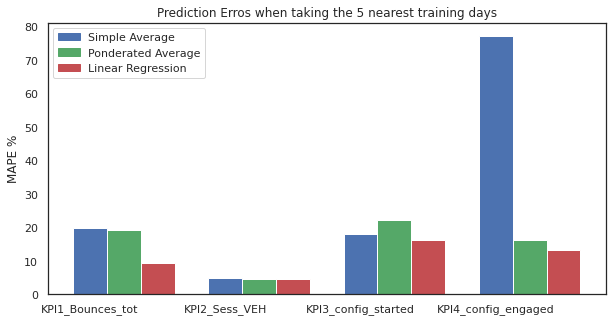

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
Simple Average,0.199144,0.0486053,0.180393,0.772977
Ponderated Average,0.191658,0.0461339,0.223584,0.163569
Linear Regression,0.0940896,0.0468108,0.1633,0.133991


In [372]:
get_errors_per_kpis_for_each_extrapolation_method(Test_target_df, mape,5 ,euclidean,Train_KPI_repartition, test_days_sampled)

Model tried : k = 5 , distance = canberra

Evaluation metric per KPIS :  mape


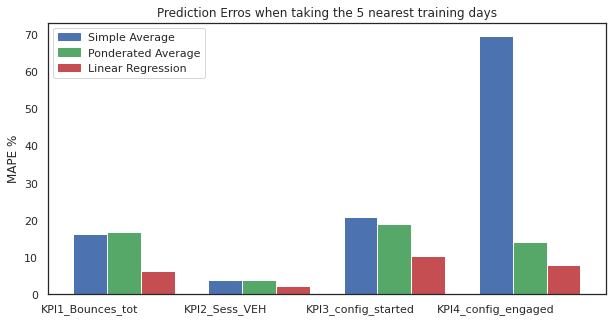

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
Simple Average,0.163491,0.0385039,0.207232,0.696719
Ponderated Average,0.168069,0.0389507,0.190577,0.140311
Linear Regression,0.0635234,0.0217907,0.103615,0.078676


In [374]:
get_errors_per_kpis_for_each_extrapolation_method(Test_target_df, mape,5 ,canberra,Train_KPI_repartition, test_days_sampled)

Model tried : k = 5 , distance = correlation

Evaluation metric per KPIS :  mape


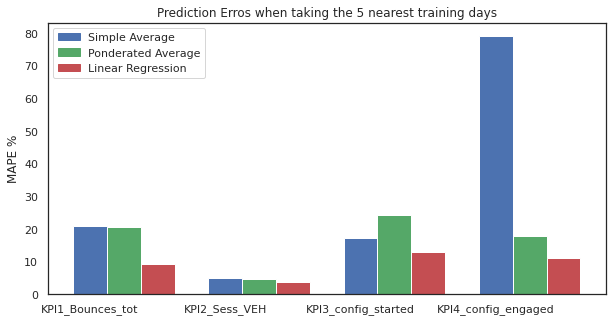

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
Simple Average,0.208227,0.0498013,0.173244,0.792056
Ponderated Average,0.205682,0.047498,0.244087,0.179245
Linear Regression,0.0918035,0.0381055,0.129086,0.112524


In [375]:
get_errors_per_kpis_for_each_extrapolation_method(Test_target_df, mape,5 ,correlation,Train_KPI_repartition, test_days_sampled)

Model tried : k = 5 , distance = braycurtis

Evaluation metric per KPIS :  mape


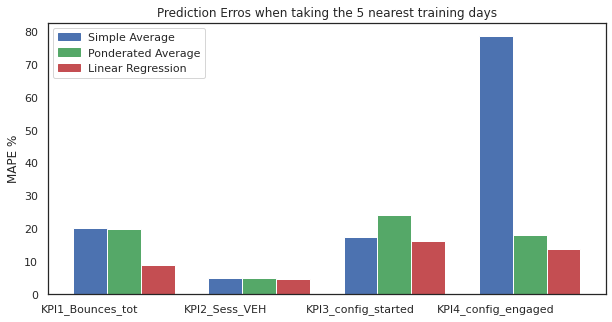

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
Simple Average,0.201896,0.0498565,0.173715,0.787272
Ponderated Average,0.199666,0.0490523,0.242065,0.179579
Linear Regression,0.0896497,0.0456054,0.161239,0.138422


In [376]:
get_errors_per_kpis_for_each_extrapolation_method(Test_target_df, mape,5 ,braycurtis,Train_KPI_repartition, test_days_sampled)

Model tried : k = 100 , distance = canberra

Evaluation metric per KPIS :  mape


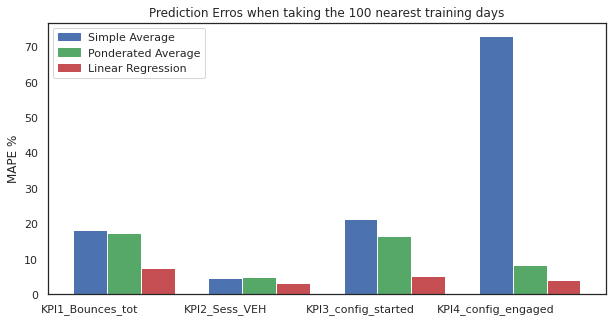

,KPI1_Bounces_tot,KPI2_Sess_VEH,KPI3_config_started,KPI4_config_engaged
Simple Average,0.182676,0.0457248,0.213691,0.731476
Ponderated Average,0.173752,0.047905,0.164184,0.0843759
Linear Regression,0.074915,0.0312698,0.0513348,0.0410844


In [380]:
get_errors_per_kpis_for_each_extrapolation_method(Test_target_df, mape,100 ,canberra, Train_KPI_repartition, test_days_sampled)

Thanks for reading ! Please check the power point presentation for the final model selection and analysis.




--Charles, Clara, Omar, Hojun & Xavier